In [6]:
#Libraries
import os
import numpy as np
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from scipy.interpolate import interp1d
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


In [2]:
def extract_glcms(image):
    # Calculate GLCM as before 
    distances = [1]#,2,3,4,5]  #distances for the GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]    #angles for the GLCM
    levels = 256

    glcm = graycomatrix(image, distances, angles, levels=levels, symmetric=True, normed=True)  #calculate the co-occurance matrix
    glcm_features = np.concatenate([graycoprops(glcm, 'contrast').ravel(),  #calculate the features
                                     graycoprops(glcm, 'dissimilarity').ravel(),
                                     graycoprops(glcm, 'homogeneity').ravel(),
                                     graycoprops(glcm, 'energy').ravel(),
                                     graycoprops(glcm, 'correlation').ravel(),
                                     graycoprops(glcm, 'ASM').ravel()])
    return glcm_features

In [3]:
def separate_and_extract_glcms(path):
    image = io.imread(path)

    #separate between rgb channels
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue= image[:, :, 2]

    #extract features
    glcm_features_r = extract_glcms(red)
    glcm_features_g = extract_glcms(green)
    glcm_features_b = extract_glcms(blue)

    return glcm_features_r, glcm_features_g, glcm_features_b

In [4]:
path = 'traintest/'

glcm_features_r_list = []
glcm_features_g_list = []
glcm_features_b_list = []

for class_name in os.listdir(path):
    #print(class_name)
    class_path = os.path.join(path, class_name)
    print(path)
    print(class_path)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                glcm_features_r, glcm_features_g, glcm_features_b = separate_and_extract_glcms(image_path)
                glcm_features_r_list.append(glcm_features_r)
                glcm_features_g_list.append(glcm_features_g)
                glcm_features_b_list.append(glcm_features_b)

glcm_features_r_array = np.array(glcm_features_r_list)
glcm_features_g_array = np.array(glcm_features_g_list)
glcm_features_b_array = np.array(glcm_features_b_list)

print('GLCM features for R ch were:', glcm_features_r_array.shape)
print('GLCM features for G ch were:', glcm_features_g_array.shape)
print('GLCM features for B ch were:', glcm_features_b_array.shape)


traintest/
traintest/0 - adenoma
traintest/
traintest/1 - hyperplasic
GLCM features for R ch were: (115, 24)
GLCM features for G ch were: (115, 24)
GLCM features for B ch were: (115, 24)


In [5]:
def extract_deep_features(image):
    preprocessed_image = preprocess_input(image)
    deep_features = model.predict(np.expand_dims(preprocessed_image, axis=0))
    #selected_features = [deep_features[0,:,:,i] for i in layers]
    return deep_features

In [11]:
class_folder_path = 'traintest/'

classes = os.listdir(class_folder_path)

deep_features_list = []
labels_list = []

#pretrained model 
model = ResNet50(weights='imagenet', include_top=False)

last_conv_layer = model.get_layer('conv5_block3_out')

#new model made from the pretrained 
deep_features_model = tf.keras.Model(inputs=model.input, outputs=last_conv_layer.output)

for i, class_name in enumerate(classes):
    class_path = os.path.join(class_folder_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        resized_image = cv2.resize(image, (224, 224))
        deep_features = extract_deep_features(resized_image)
        deep_features_list.append(deep_features)
        labels_list.append(class_name)

deep_features_array = np.array(deep_features_list)
flattened_deep_features = deep_features_array.reshape(deep_features_array.shape[0], -1)
labels_array = np.array(labels_list)

print('Deep Features shape:', flattened_deep_features.shape)
print('Labels shape:', labels_array.shape)


1/1 [==============================] - 0s 93ms/step
Deep Features shape: (115, 100352)
Labels shape: (115,)


In [11]:
#por ahora no tocar!! #do not touch
import os
import numpy as np
from skimage import io
from skimage.transform import resize
#from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Path to the folder containing the class folders
class_folder_path = 'traintest'
#classes = ['class1', 'class2', 'class3']

classes= os.listdir(class_folder_path)
#print(classes)

deep_features_list = []
labels_list = []

# Load the pre-trained DenseNet201 model
model = ResNet50(weights='imagenet', include_top=False)
#layers = [4, 6, 14, 19, 22, 23]

def extract_deep_features(image):
    preprocessed_image = preprocess_input(image)
    deep_features = model.predict(np.expand_dims(preprocessed_image, axis=0))
    #selected_features = [deep_features[0,:,:,i] for i in layers]
    return deep_features

for i, class_name in enumerate(classes):
    class_path = os.path.join(class_folder_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #plt.imshow(image)
        #plt.show()

        resized_image = cv2.resize(image, (224, 224))
        deep_features = extract_deep_features(resized_image)
        print(deep_features.shape)
        deep_features_list.append(deep_features)
        #print(deep_features_list)
        labels_list.append(class_name)
        print(labels_list)

deep_features_array = np.concatenate(deep_features_list)
flattened_deep_features = deep_features_array.reshape(deep_features_array.shape[0], -1)
labels_array = np.array(labels_list)

print('Deep Features shape:', deep_features_array.shape)
print('Labels shape:', labels_array.shape)

1/1 [==============================] - 1s 1s/step
(1, 7, 7, 2048)
['0 - adenoma']
1/1 [==============================] - 0s 139ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 130ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 156ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 174ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 139ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 152ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma', '0 - adenoma']
1/1 [==============================] - 0s 128ms/step
(1, 7, 7, 2048)
['0 - adenoma', '0 - ade

combino esto (115, 72)
con esto (115, 100352)
(115,)
(115, 100424)


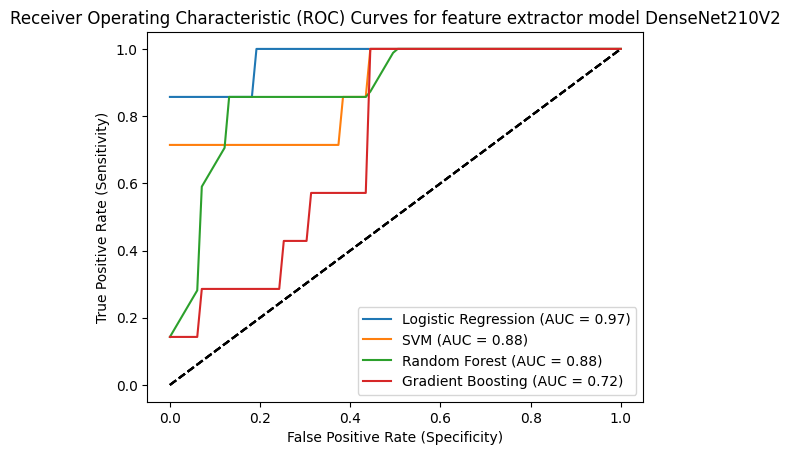

accuracies [0.8260869565217391, 0.782608695652174, 0.782608695652174, 0.6086956521739131]
TN [13, 13, 15, 10]
FP [3, 3, 1, 6]
FN [1, 2, 4, 3]
TP [6, 5, 3, 4]
precision [0.6666666666666666, 0.625, 0.75, 0.4]
recall [0.8571428571428571, 0.7142857142857143, 0.42857142857142855, 0.5714285714285714]
f1 acore [0.75, 0.6666666666666666, 0.5454545454545454, 0.47058823529411764]
specificity [0.8125, 0.8125, 0.9375, 0.625]
sensitiviy [0.8571428571428571, 0.7142857142857143, 0.42857142857142855, 0.5714285714285714]


In [12]:
combined_glcms = np.concatenate((glcm_features_r_array, glcm_features_g_array, glcm_features_b_array), axis=1)
print("combino esto", combined_glcms.shape)
print("con esto", flattened_deep_features.shape)
print(labels_array.shape)
combined_features = np.concatenate((combined_glcms, flattened_deep_features), axis=1)
print(combined_features.shape)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels_array, test_size=0.2, random_state=42)

# Transform labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create classifiers
lr_classifier = classifier = LogisticRegression(max_iter=1000)

svm_classifier = svm.SVC(probability=True)
rf_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()

classifiers = [lr_classifier, svm_classifier, rf_classifier, gb_classifier]
classifier_labels = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']
accuracy_list = []
TN_list = []
FN_list = []
TP_list = []
FP_list = []
precision_list = []
recall_list = []
f1_list = []
specificity_list = []
plt.figure()

for classifier, label in zip(classifiers, classifier_labels):
    classifier.fit(X_train, y_train_encoded)
    y_scores = classifier.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)
    interp_fpr = np.linspace(0, 1, 100)
    interp_tpr = interp1d(fpr, tpr)(interp_fpr)
    auc_score = auc(interp_fpr, interp_tpr)
    y_pred_proba = classifier.predict_proba(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    label_encoder = LabelEncoder()
    y_true = label_encoder.fit_transform(y_test)

    accuracy = accuracy_score(y_true, y_pred)   #calculate accuracy
    accuracy_list.append(accuracy)
    cm = confusion_matrix(y_true, y_pred)       #calculate confusion matrix 
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    FN = cm[1, 0]  # False negatives
    TP = cm[1, 1]  # True positives
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)
    TP_list.append(TP)

    #PRECISION RECALL AND F1
    precision = precision_score(y_true, y_pred)
    precision_list.append(precision)
    recall = recall_score(y_true, y_pred)
    recall_list.append(recall)
    f1 = f1_score(y_true, y_pred)
    f1_list.append(f1)

    #specificity and sensitivity
    true_negative = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    false_positive = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    specificity = true_negative / (true_negative + false_positive)
    specificity_list.append(specificity)
    sensitivity = recall

    #plot roc
    plt.plot(interp_fpr, interp_tpr, label=f'{label} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
    plt.xlabel('False Positive Rate (Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curves for feature extractor model DenseNet210V2')
    plt.legend(loc='lower right')
plt.show()

print('accuracies', accuracy_list)    #show accuracy

print('TN', TN_list)  #show confusion matrix values
print('FP', FP_list)
print('FN', FN_list)
print('TP', TP_list)

print('precision', precision_list)
print('recall', recall_list)
print('f1 acore', f1_list)
print('specificity', specificity_list)
print('sensitiviy', recall_list)

TEST

In [7]:
test_path = "tests/"

glcm_features_r_list_test = []
glcm_features_g_list_test = []
glcm_features_b_list_test = []

class_folders = os.listdir(test_path)

for class_folder in class_folders:
    class_folder_path = os.path.join(test_path, class_folder)
    if not os.path.isdir(class_folder_path):
        continue
    
    for img in os.listdir(class_folder_path):
        img_path = os.path.join(class_folder_path, img)
        #img = cv2.imread(img_path)
        #cv2.imshow('Image', img)
        #plt.imshow(img, cmap='gray')
        #plt.show()
        print(img_path)
        glcm_features_r_test, glcm_features_g_test, glcm_features_b_test = separate_and_extract_glcms(img_path)
        glcm_features_r_list_test.append(glcm_features_r_test)
        glcm_features_g_list_test.append(glcm_features_g_test)
        glcm_features_b_list_test.append(glcm_features_b_test)

# Convert the lists to NumPy arrays
glcm_features_r_array_test = np.array(glcm_features_r_list_test)
glcm_features_g_array_test = np.array(glcm_features_g_list_test)
glcm_features_b_array_test = np.array(glcm_features_b_list_test)

print('GLCM features for R channel:', glcm_features_r_array_test.shape)
print('GLCM features for G channel:', glcm_features_g_array_test.shape)
print('GLCM features for B channel:', glcm_features_b_array_test.shape)

tests/0 - adenoma\a (1).jpg
tests/0 - adenoma\a (10).jpg
tests/0 - adenoma\a (11).jpg
tests/0 - adenoma\a (2).jpg
tests/0 - adenoma\a (3).jpg
tests/0 - adenoma\a (4).jpg
tests/0 - adenoma\a (5).jpg
tests/0 - adenoma\a (6).jpg
tests/0 - adenoma\a (7).jpg
tests/0 - adenoma\a (8).jpg
tests/0 - adenoma\a (9).jpg
tests/0 - adenoma\a33.jpg
tests/0 - adenoma\a34.jpg
tests/0 - adenoma\a63.jpg
tests/0 - adenoma\a65.jpg
tests/1 - hyperplasic\h (1).jpg
tests/1 - hyperplasic\h (2).jpg
tests/1 - hyperplasic\h (3).jpg
tests/1 - hyperplasic\h (4).jpg
tests/1 - hyperplasic\h (5).jpg
tests/1 - hyperplasic\h (6).jpg
tests/1 - hyperplasic\h (7).jpg
tests/1 - hyperplasic\h.jpg
tests/1 - hyperplasic\h15.jpg
tests/1 - hyperplasic\h27.jpg
tests/1 - hyperplasic\h30.jpg
GLCM features for R channel: (26, 24)
GLCM features for G channel: (26, 24)
GLCM features for B channel: (26, 24)


In [8]:
import os
import cv2
import matplotlib.pyplot as plt

deep_features_list_test = []
labels_list_test = []
classes = os.listdir(test_path)

for i, class_name in enumerate(classes):
    class_path = os.path.join(test_path, class_name)
    images = os.listdir(class_path)

    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        resized_image_test = cv2.resize(image, (224, 224))
        deep_features_test = extract_deep_features(resized_image_test)
        print(deep_features_test.shape)
        deep_features_list_test.append(deep_features_test)
        #print(deep_features_list)
        labels_list_test.append(class_name)
        #print(labels_list)

deep_features_array_test = np.concatenate(deep_features_list_test)
flattened_deep_features_test = deep_features_array_test.reshape(deep_features_array_test.shape[0], -1)
print(flattened_deep_features_test.shape)
print(labels_list_test)


1/1 [==============================] - 0s 116ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 133ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 165ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 123ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 136ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 243ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 218ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 174ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 136ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 130ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 121ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 141ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 132ms/step
(1, 7, 7, 2048)
1/1 [==============================] - 0s 133ms/step
(1, 7, 7, 2048)
1/1 [=============================

In [9]:
combined_glcms_test = np.concatenate((glcm_features_r_array_test, glcm_features_g_array_test, glcm_features_b_array_test), axis=1)
print(combined_glcms_test.shape)
#combined_glcms = np.repeat(combined_glcms, 7, axis=0)
print(combined_glcms_test.shape)
print(flattened_deep_features_test.shape)
#combined_glcms_test = np.repeat(combined_glcms_test, 63, axis=0)
print(combined_glcms_test.shape)
combined_features_test = np.concatenate((combined_glcms_test, flattened_deep_features_test), axis=1)
print(combined_features_test.shape)

(26, 72)
(26, 72)
(26, 100352)
(26, 72)
(26, 100424)


In [10]:
pred_test = classifier.predict(combined_features_test)
labels_array_test = np.array(labels_list_test)
#print(pred_test.shape)
#print(labels_array_test)

        
for i, prediction in enumerate(pred_test):
    print("The prediction for the picture is", prediction, "The ground truth was", labels_array_test[i])#labels_list_test[i])


The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic The ground truth was 0 - adenoma
The prediction for the picture is 1 - hyperplasic The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenoma The ground truth was 0 - adenoma
The prediction for the picture is 0 - adenom